# Checkpoint 5: CNNs for Visual Reinforcement Learning

In this notebook, we explore how Convolutional Neural Networks (CNNs) enable reinforcement learning agents to learn directly from visual input. We'll train a PPO agent to play Atari Pong using raw pixel observations.

## Learning Objectives
- Understand why CNNs are essential for visual RL
- Learn the NatureCNN architecture used in DQN and PPO
- Understand frame stacking and Atari preprocessing
- Train a CNN-based agent on Pong

## 1. Installation

First, let's install the required packages for Atari environments and deep RL.

In [12]:
# Install required packages
!pip install -q "gymnasium[atari,accept-rom-license]" stable-baselines3 torch numpy matplotlib opencv-python "autorom[accept-rom-license]"

# Accept ROM license and download ROMs
!python -m autorom --accept-license --quiet 2>/dev/null || echo "ROMs already installed or AutoROM not needed"


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
ROMs already installed or AutoROM not needed


## 2. RunPod Display Setup

When running on headless servers (like RunPod, Colab, or remote machines), we need to configure the display driver to work without a physical monitor.

In [13]:
import os

# Set SDL to use dummy video driver (no display needed)
os.environ['SDL_VIDEODRIVER'] = 'dummy'

# Additional headless settings
os.environ['DISPLAY'] = ''
os.environ['MPLBACKEND'] = 'Agg'

print("Display configured for headless operation")
print(f"SDL_VIDEODRIVER: {os.environ.get('SDL_VIDEODRIVER', 'not set')}")

Display configured for headless operation
SDL_VIDEODRIVER: dummy


## 3. GPU Check

CNNs are computationally intensive. Let's check if we have GPU acceleration available.

In [14]:
import torch

print("=" * 50)
print("GPU AVAILABILITY CHECK")
print("=" * 50)

if torch.cuda.is_available():
    print(f"CUDA Available: Yes")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        
        # Memory info
        total_memory = torch.cuda.get_device_properties(i).total_memory / (1024**3)
        allocated = torch.cuda.memory_allocated(i) / (1024**3)
        cached = torch.cuda.memory_reserved(i) / (1024**3)
        
        print(f"  Total Memory: {total_memory:.2f} GB")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Cached: {cached:.2f} GB")
        print(f"  Free: {total_memory - allocated:.2f} GB")
    
    device = "cuda"
else:
    print("CUDA Available: No")
    print("Training will run on CPU (slower)")
    device = "cpu"

print(f"\nUsing device: {device}")
print("=" * 50)

GPU AVAILABILITY CHECK
CUDA Available: Yes
CUDA Version: 12.4
Number of GPUs: 1

GPU 0: NVIDIA GeForce RTX 3090
  Total Memory: 23.57 GB
  Allocated: 0.04 GB
  Cached: 0.14 GB
  Free: 23.53 GB

Using device: cuda


## 4. Imports

In [15]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output

# Register ALE environments with Gymnasium (required for Gymnasium 1.0.0+)
import ale_py
gym.register_envs(ale_py)

# Stable Baselines 3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

# For visualizing the CNN architecture
import torch.nn as nn

print("All imports successful!")
print(f"Gymnasium version: {gym.__version__}")

All imports successful!
Gymnasium version: 1.2.3


## 5. Theory: Why CNNs for Visual Input?

### The Challenge of Visual RL

When an agent receives raw pixel observations, the input space is enormous:
- A 210x160 RGB Atari frame = 210 x 160 x 3 = **100,800 dimensions**
- A fully connected network would need millions of parameters just for the first layer!

### Why CNNs Are the Solution

**1. Spatial Hierarchies**
- Early layers detect simple features (edges, colors)
- Middle layers detect patterns (shapes, textures)
- Later layers detect objects (paddle, ball, score)

**2. Weight Sharing**
- The same filter is applied across the entire image
- Dramatically reduces parameters (thousands instead of millions)
- A 3x3 filter has only 9 learnable weights, but can detect features anywhere in the image

**3. Translation Invariance**
- A ball is a ball regardless of where it appears on screen
- CNNs naturally learn position-independent features

**4. Local Connectivity**
- Each neuron only connects to a small region (receptive field)
- Neighboring pixels are more relevant than distant ones
- This matches the structure of visual data

### Visual Representation

```
Raw Pixels (210x160x3)     CNN Layers              Action Values
     [Image]          ->   [Conv1] ->              
                          [Conv2] ->      ->      [Up, Down, Stay]
                          [Conv3] ->  [FC]
                          [Flatten]
```

## 6. Theory: The NatureCNN Architecture

The **NatureCNN** architecture was introduced in the famous DQN paper (Mnih et al., 2015) and has become the standard for visual RL.

### Architecture Details

```
Input: 84 x 84 x 4 (4 stacked grayscale frames)
         |
         v
    Conv2D Layer 1
    - 32 filters, 8x8 kernel, stride 4
    - Output: 20 x 20 x 32
    - ReLU activation
         |
         v
    Conv2D Layer 2
    - 64 filters, 4x4 kernel, stride 2
    - Output: 9 x 9 x 64
    - ReLU activation
         |
         v
    Conv2D Layer 3
    - 64 filters, 3x3 kernel, stride 1
    - Output: 7 x 7 x 64
    - ReLU activation
         |
         v
    Flatten
    - Output: 7 * 7 * 64 = 3136
         |
         v
    Fully Connected Layer
    - 512 units
    - ReLU activation
         |
         v
    Output Layer
    - Policy head (action probabilities)
    - Value head (state value estimate)
```

### Key Design Choices

1. **Large first kernel (8x8)**: Captures coarse features quickly
2. **Decreasing kernel sizes**: Finer features at higher levels
3. **Increasing filter counts**: More complex feature combinations
4. **No pooling layers**: Strides handle downsampling (preserves spatial info for RL)
5. **Total parameters**: ~1.7 million (manageable for real-time games)

## 7. Theory: Frame Stacking - Encoding Motion

### The Problem: Single Frames Lack Temporal Information

A single frame is a **snapshot** - it shows WHERE objects are, but not:
- Which direction the ball is moving
- How fast objects are traveling
- Whether the paddle was just hit

### The Solution: Stack Multiple Frames

By stacking the last 4 frames, we implicitly encode **velocity** and **acceleration**:

```
Frame t-3    Frame t-2    Frame t-1    Frame t (current)
   [ ]          [ ]          [ ]           [ ]
   [O]         [ O]         [  O]         [   O]   <- Ball moving right!
   [ ]          [ ]          [ ]           [ ]
```

The CNN can learn that:
- **Position difference** across frames = velocity
- **Velocity difference** across frames = acceleration

### Why 4 Frames?

- **2 frames**: Can compute velocity but not acceleration
- **4 frames**: Good balance of temporal info and memory usage
- **More frames**: Diminishing returns, more computation

### Memory Format

```python
# Observation shape after stacking
observation.shape = (84, 84, 4)  # or (4, 84, 84) depending on channel order

# Channel 0: Frame t-3 (oldest)
# Channel 1: Frame t-2
# Channel 2: Frame t-1
# Channel 3: Frame t (newest)
```

## 8. Theory: Atari Preprocessing Pipeline

Raw Atari frames undergo several preprocessing steps to make learning tractable:

### 1. Grayscale Conversion
- **Raw**: 210 x 160 x 3 (RGB)
- **After**: 210 x 160 x 1
- **Why**: Color often irrelevant for gameplay, reduces computation by 3x

### 2. Resize to 84x84
- **Raw**: 210 x 160
- **After**: 84 x 84
- **Why**: Smaller images = faster training, important features preserved

### 3. Frame Skip (Action Repeat)
- **What**: Repeat each action for 4 frames
- **Why**: 
  - Faster training (4x fewer decisions)
  - Longer-term action consequences
  - Original Atari ran at 60 FPS (too fast for meaningful decisions)

### 4. Max-Pooling Over Frames
- **What**: Take pixel-wise max of last 2 frames before skip
- **Why**: Handles Atari's sprite flickering (some objects only appear every other frame)

### 5. Sticky Actions (Optional)
- **What**: 25% chance previous action is repeated instead of new action
- **Why**: Adds stochasticity, prevents memorization of deterministic games

### Complete Pipeline

```
Raw Frame (210x160 RGB)
    |
    v
Grayscale (210x160)
    |
    v
Resize (84x84)
    |
    v
Normalize to [0, 1]
    |
    v
Stack 4 frames (84x84x4)
    |
    v
Ready for CNN!
```

## 9. Create Pong Environment

Let's create a properly wrapped Atari Pong environment with all the standard preprocessing.

In [16]:
  !pip install ale-py --root-user-action=ignore                                                                                         
  !pip install "gymnasium[atari,accept-rom-license]" --root-user-action=ignore   


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [17]:
# Create vectorized Atari environment with standard wrappers
# make_atari_env automatically applies:
# - NoopResetEnv: Random number of no-ops at start
# - MaxAndSkipEnv: Frame skipping with max pooling
# - EpisodicLifeEnv: End episode on life loss (for training)
# - FireResetEnv: Press FIRE to start (for games that need it)
# - WarpFrame: Resize to 84x84 grayscale
# - ClipRewardEnv: Clip rewards to {-1, 0, 1}

env = make_atari_env(
    "ALE/Pong-v5",         # Pong environment from ALE namespace
    n_envs=4,              # 4 parallel environments for faster data collection
    seed=42
)

# Add frame stacking
env = VecFrameStack(env, n_stack=4)

print("Environment created successfully!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Number of parallel environments: {env.num_envs}")

# Show action meanings
print("\nAction meanings:")
print("0: NOOP")
print("1: FIRE")
print("2: RIGHT (paddle up)")
print("3: LEFT (paddle down)")
print("4: RIGHTFIRE")
print("5: LEFTFIRE")

Environment created successfully!
Observation space: Box(0, 255, (84, 84, 4), uint8)
Action space: Discrete(6)
Number of parallel environments: 4

Action meanings:
0: NOOP
1: FIRE
2: RIGHT (paddle up)
3: LEFT (paddle down)
4: RIGHTFIRE
5: LEFTFIRE


## 10. Visualize Raw vs Processed Observations

Let's see the difference between raw Atari frames and the processed observations our CNN receives.

In [18]:
# Create a raw environment to compare
raw_env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

# Reset both environments
raw_obs, _ = raw_env.reset(seed=42)
processed_obs = env.reset()

# Take a few random actions to get interesting frames
for _ in range(50):
    action = raw_env.action_space.sample()
    raw_obs, _, terminated, truncated, _ = raw_env.step(action)
    if terminated or truncated:
        raw_obs, _ = raw_env.reset()
    
    # Same for processed env (need array of actions for vectorized env)
    processed_obs, _, _, _ = env.step([action] * env.num_envs)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Raw observation
axes[0].imshow(raw_obs)
axes[0].set_title(f"Raw Observation\nShape: {raw_obs.shape}\n(210x160 RGB)")
axes[0].axis('off')

# Processed single frame (last frame of stack)
single_processed = processed_obs[0, :, :, -1]  # Last frame of first env
axes[1].imshow(single_processed, cmap='gray')
axes[1].set_title(f"Processed Frame\nShape: {single_processed.shape}\n(84x84 Grayscale)")
axes[1].axis('off')

# Full stacked observation
axes[2].imshow(processed_obs[0, :, :, 0], cmap='gray', alpha=0.3)
axes[2].imshow(processed_obs[0, :, :, 1], cmap='gray', alpha=0.3)
axes[2].imshow(processed_obs[0, :, :, 2], cmap='gray', alpha=0.5)
axes[2].imshow(processed_obs[0, :, :, 3], cmap='gray', alpha=0.7)
axes[2].set_title(f"4-Frame Stack (overlaid)\nShape: {processed_obs[0].shape}\n(84x84x4)")
axes[2].axis('off')

plt.tight_layout()
plt.savefig('raw_vs_processed.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nRaw observation size: {raw_obs.nbytes / 1024:.2f} KB")
print(f"Processed observation size: {processed_obs[0].nbytes / 1024:.2f} KB")
print(f"Compression ratio: {raw_obs.nbytes / processed_obs[0].nbytes:.1f}x")

raw_env.close()


Raw observation size: 98.44 KB
Processed observation size: 27.56 KB
Compression ratio: 3.6x


## 11. Visualize 4 Stacked Frames Showing Motion

Let's visualize each of the 4 stacked frames to see how motion is encoded.

In [19]:
# Reset and take some actions to get ball movement
obs = env.reset()

# Play for a bit to get ball in motion
for _ in range(30):
    obs, _, _, _ = env.step([2, 2, 2, 2])  # Move paddle up

# Now show all 4 frames
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

frame_labels = ['Frame t-3 (oldest)', 'Frame t-2', 'Frame t-1', 'Frame t (current)']

for i in range(4):
    frame = obs[0, :, :, i]  # Get frame i from first environment
    axes[i].imshow(frame, cmap='gray')
    axes[i].set_title(frame_labels[i])
    axes[i].axis('off')

plt.suptitle('4 Stacked Frames - Notice Ball/Paddle Position Changes Over Time', fontsize=14)
plt.tight_layout()
plt.savefig('stacked_frames.png', dpi=100, bbox_inches='tight')
plt.show()

# Show the difference between frames to highlight motion
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

diff_labels = ['Diff (t-2) - (t-3)', 'Diff (t-1) - (t-2)', 'Diff t - (t-1)']

for i in range(3):
    frame_diff = obs[0, :, :, i+1].astype(np.float32) - obs[0, :, :, i].astype(np.float32)
    # Normalize diff for visualization
    frame_diff = (frame_diff - frame_diff.min()) / (frame_diff.max() - frame_diff.min() + 1e-8)
    axes[i].imshow(frame_diff, cmap='RdBu')
    axes[i].set_title(diff_labels[i])
    axes[i].axis('off')

plt.suptitle('Frame Differences - Red/Blue Shows Motion Between Frames', fontsize=14)
plt.tight_layout()
plt.savefig('frame_differences.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nKey insight: The CNN learns to interpret these stacked frames")
print("to understand velocity and predict where objects will be!")


Key insight: The CNN learns to interpret these stacked frames
to understand velocity and predict where objects will be!


## 12. Create PPO Model with CnnPolicy

Now let's create a PPO agent that uses the NatureCNN architecture.

In [20]:
# Create PPO model with CNN policy
model = PPO(
    "CnnPolicy",           # Automatically uses NatureCNN for image observations
    env,
    learning_rate=2.5e-4,  # Standard Atari learning rate
    n_steps=128,           # Steps per environment per update
    batch_size=256,        # Minibatch size
    n_epochs=4,            # Epochs per update
    gamma=0.99,            # Discount factor
    gae_lambda=0.95,       # GAE lambda
    clip_range=0.1,        # PPO clip range
    ent_coef=0.01,         # Entropy coefficient for exploration
    verbose=1,
    device=device,
    tensorboard_log="./pong_tensorboard/"
)

print("\n" + "="*60)
print("PPO MODEL WITH NATURECNN ARCHITECTURE")
print("="*60)

# Print the policy architecture
print("\nPolicy Network Architecture:")
print(model.policy)

# Count parameters
total_params = sum(p.numel() for p in model.policy.parameters())
trainable_params = sum(p.numel() for p in model.policy.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using cuda device
Wrapping the env in a VecTransposeImage.

PPO MODEL WITH NATURECNN ARCHITECTURE

Policy Network Architecture:
ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Lin

In [21]:
# Let's examine the CNN feature extractor in detail
print("\n" + "="*60)
print("CNN FEATURE EXTRACTOR DETAILS")
print("="*60)

cnn = model.policy.features_extractor
print(f"\nFeature extractor type: {type(cnn).__name__}")
print(f"Features dimension: {cnn.features_dim}")

print("\nLayer-by-layer breakdown:")
print("-" * 40)

# Manually trace through the CNN
input_shape = (4, 84, 84)  # 4 stacked frames
print(f"Input: {input_shape}")

# The NatureCNN structure
layers_info = [
    ("Conv2D", "32 filters, 8x8, stride 4", (32, 20, 20)),
    ("ReLU", "activation", (32, 20, 20)),
    ("Conv2D", "64 filters, 4x4, stride 2", (64, 9, 9)),
    ("ReLU", "activation", (64, 9, 9)),
    ("Conv2D", "64 filters, 3x3, stride 1", (64, 7, 7)),
    ("ReLU", "activation", (64, 7, 7)),
    ("Flatten", "7*7*64 = 3136", (3136,)),
    ("Linear", "512 units", (512,)),
    ("ReLU", "activation", (512,)),
]

for name, desc, shape in layers_info:
    print(f"  {name:10} | {desc:25} | Output: {shape}")

print("-" * 40)
print("\nAfter features extractor:")
print("  -> Policy head (MLP) -> Action logits (6 actions)")
print("  -> Value head (MLP) -> State value (1 scalar)")


CNN FEATURE EXTRACTOR DETAILS

Feature extractor type: NatureCNN
Features dimension: 512

Layer-by-layer breakdown:
----------------------------------------
Input: (4, 84, 84)
  Conv2D     | 32 filters, 8x8, stride 4 | Output: (32, 20, 20)
  ReLU       | activation                | Output: (32, 20, 20)
  Conv2D     | 64 filters, 4x4, stride 2 | Output: (64, 9, 9)
  ReLU       | activation                | Output: (64, 9, 9)
  Conv2D     | 64 filters, 3x3, stride 1 | Output: (64, 7, 7)
  ReLU       | activation                | Output: (64, 7, 7)
  Flatten    | 7*7*64 = 3136             | Output: (3136,)
  Linear     | 512 units                 | Output: (512,)
  ReLU       | activation                | Output: (512,)
----------------------------------------

After features extractor:
  -> Policy head (MLP) -> Action logits (6 actions)
  -> Value head (MLP) -> State value (1 scalar)


## 13. Train the Model

Updated to a million to see if we can do something.

In [22]:
# Custom callback for progress tracking
class ProgressCallback(BaseCallback):
    def __init__(self, check_freq=10000, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.episode_rewards = []
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            # Get episode rewards from the monitor
            if len(self.model.ep_info_buffer) > 0:
                mean_reward = np.mean([ep['r'] for ep in self.model.ep_info_buffer])
                mean_length = np.mean([ep['l'] for ep in self.model.ep_info_buffer])
                print(f"\nStep {self.n_calls:,}:")
                print(f"  Mean reward: {mean_reward:.2f}")
                print(f"  Mean episode length: {mean_length:.0f}")
        return True

# Train the model
print("Starting training...")
print("Note: Full training typically requires 1-10 million timesteps.")
print("Million steps to see how it does")
print("="*60)

callback = ProgressCallback(check_freq=25000)

model.learn(
    total_timesteps=1_000_000,
    callback=callback,
    progress_bar=False  # Disabled due to rich/Jupyter compatibility issues
)

print("\n" + "="*60)
print("Training complete!")
print("="*60)

Starting training...
Note: Full training typically requires 1-10 million timesteps.
Million steps to see how it does
Logging to ./pong_tensorboard/PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 764      |
|    ep_rew_mean     | -21      |
| time/              |          |
|    fps             | 380      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 872          |
|    ep_rew_mean          | -20.8        |
| time/                   |              |
|    fps                  | 324          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0020231013 |
|    clip_fraction        | 0     

In [23]:
# Save the model
model.save("ppo_pong_200k")
print("Model saved as 'ppo_pong_200k.zip'")

Model saved as 'ppo_pong_200k.zip'


## 14. Evaluate and Visualize Gameplay

Let's evaluate our trained agent and visualize some gameplay frames.

In [24]:
# Create a separate environment for evaluation
eval_env = make_atari_env("ALE/Pong-v5", n_envs=1, seed=123)
eval_env = VecFrameStack(eval_env, n_stack=4)

# Evaluate the model
print("Evaluating trained agent...")
mean_reward, std_reward = evaluate_policy(
    model, 
    eval_env, 
    n_eval_episodes=10,
    deterministic=True
)

print(f"\nEvaluation Results (10 episodes):")
print(f"  Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
print(f"\nNote: Pong rewards range from -21 to +21")
print(f"  -21 = Agent lost all points")
print(f"    0 = Tied game")
print(f"  +21 = Agent won all points")

eval_env.close()

Evaluating trained agent...

Evaluation Results (10 episodes):
  Mean reward: -18.30 +/- 1.35

Note: Pong rewards range from -21 to +21
  -21 = Agent lost all points
    0 = Tied game
  +21 = Agent won all points


In [25]:
# Collect gameplay frames for visualization
vis_env = make_atari_env("ALE/Pong-v5", n_envs=1, seed=456)
vis_env = VecFrameStack(vis_env, n_stack=4)

# Also create a raw environment to get RGB frames
raw_vis_env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

frames = []
obs = vis_env.reset()
raw_obs, _ = raw_vis_env.reset(seed=456)

print("Collecting gameplay frames...")

# Synchronize environments roughly
for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    
    # Step both environments
    obs, reward, done, info = vis_env.step(action)
    raw_obs, _, raw_done, raw_trunc, _ = raw_vis_env.step(action[0])
    
    # Collect frame every few steps
    if len(frames) < 20:
        frames.append(raw_obs.copy())
    
    if raw_done or raw_trunc:
        raw_obs, _ = raw_vis_env.reset()

# Visualize gameplay frames
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, frame in enumerate(frames[:10]):
    axes[i].imshow(frame)
    axes[i].set_title(f"Frame {i+1}")
    axes[i].axis('off')

plt.suptitle('Sample Gameplay Frames from Trained Agent', fontsize=14)
plt.tight_layout()
plt.savefig('gameplay_frames.png', dpi=100, bbox_inches='tight')
plt.show()

vis_env.close()
raw_vis_env.close()

print("\nGameplay visualization complete!")


Gameplay visualization complete!


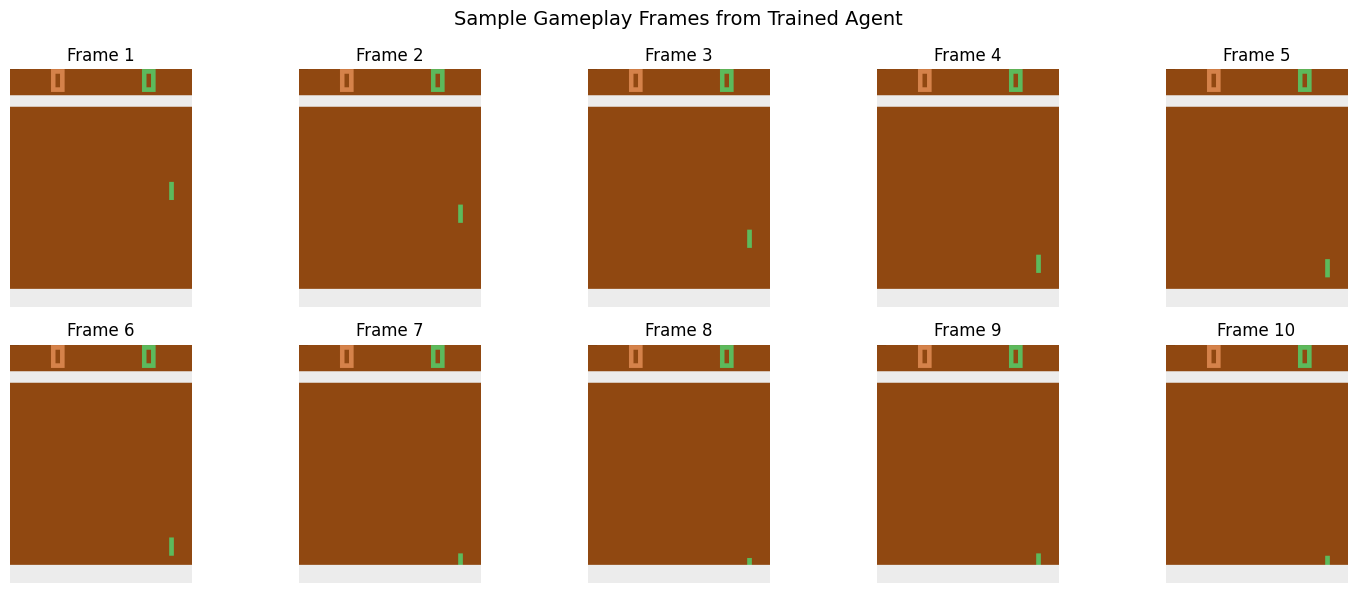

In [27]:
from IPython.display import Image; Image('gameplay_frames.png')   

## 15. Quiz: Test Your Understanding

Answer these questions to check your understanding of CNNs for visual RL.

---

**Question 1**: Why are CNNs preferred over fully connected networks for visual input?

A) CNNs are always faster to train  
B) CNNs exploit spatial structure through weight sharing and local connectivity  
C) CNNs don't require preprocessing  
D) CNNs can only be used with images

---

**Question 2**: What information does frame stacking provide that a single frame cannot?

A) Higher resolution images  
B) Color information  
C) Temporal information like velocity and acceleration  
D) Sound data

---

**Question 3**: Why do we resize Atari frames to 84x84?

A) It's the native resolution of Atari games  
B) To reduce computational cost while preserving important features  
C) The NatureCNN only works with 84x84 images  
D) To increase the amount of training data

---

**Question 4**: In the NatureCNN architecture, what is the purpose of using stride instead of pooling?

A) Stride is computationally cheaper  
B) Pooling doesn't work with CNNs  
C) Stride preserves more spatial information needed for RL decisions  
D) There is no difference between stride and pooling

---

**Question 5**: Why do Atari preprocessing pipelines clip rewards to {-1, 0, 1}?

A) Atari games only have these three reward values  
B) To normalize rewards across different games with varying score scales  
C) To make the game easier  
D) To reduce memory usage

---

### Answers

<details>
<summary>Click to reveal answers</summary>

1. **B** - CNNs exploit spatial structure through weight sharing (same filter across image) and local connectivity (each neuron connects to a small region), making them much more parameter-efficient for images.

2. **C** - Frame stacking provides temporal information. By seeing object positions across multiple frames, the network can infer velocity (position change) and acceleration (velocity change).

3. **B** - Resizing to 84x84 significantly reduces computational cost (fewer pixels to process) while still preserving the important features needed for gameplay decisions.

4. **C** - Unlike pooling which loses spatial information through max/average operations, stride preserves the learned features' spatial relationships, which is important for making spatially-aware decisions in RL.

5. **B** - Different Atari games have vastly different score scales (Pong: +/-21, Space Invaders: hundreds). Clipping normalizes rewards so the same hyperparameters can work across games.

</details>

## 16. Cleanup

Let's clean up our environments and free resources.

In [26]:
# Close the main training environment
env.close()

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU memory cache cleared")

print("Cleanup complete!")
print("\n" + "="*60)
print("CHECKPOINT 5 COMPLETE!")
print("="*60)
print("\nKey Takeaways:")
print("1. CNNs enable learning from raw pixel observations")
print("2. The NatureCNN architecture is the standard for visual RL")
print("3. Frame stacking encodes temporal information (velocity)")
print("4. Atari preprocessing (grayscale, resize, clip) is essential")
print("5. Training visual RL agents requires significant compute")
print("\nNext: Explore the Gymnasium API and custom wrappers!")

GPU memory cache cleared
Cleanup complete!

CHECKPOINT 5 COMPLETE!

Key Takeaways:
1. CNNs enable learning from raw pixel observations
2. The NatureCNN architecture is the standard for visual RL
3. Frame stacking encodes temporal information (velocity)
4. Atari preprocessing (grayscale, resize, clip) is essential
5. Training visual RL agents requires significant compute

Next: Explore the Gymnasium API and custom wrappers!
